   # Problem Statement :

Company  XYZ has a list of sales leads that potentially could develop into a business opportunity. 
To maximize the quality of these leads, XYZ is developing a lead management process, involving system and machine learning algorithms, eventually distributing leads to the sales team for closing. 

The initial contact lead information (including First Name, Last Name, Mailing Street, Mailing State, Mailing Zip, 
and Phone) have already been provided. 
Additional attributes such as “Phone to Name Match" and "Address to Name Match" are generated from matching 
contacts against XYZ’s customer management system database. 

The Lead_Verifiy_Response file includes a sample  of contacts along with each contact’s corresponding attributes(features) and call outcome. Each record/row includes  the contact’s name, address, phone number, and the contact’s 10 features along with outcome.

Input Features Set :

1) Phone to Name Match , 2)Phone Is Valid <BR>
3) Phone Line Type, 4)Phone Prepaid <BR>
5)Phone Is Commercial,6)Address to Name Match<BR>
7)Address Is Valid, 8)Address Type<BR>
9)Address Is Active, 10)Address Is Commercial <BR>

<BR>
Outcome(Label) <BR>
Call Disposition: ranges from 1 to 6


# Objective of analysis:

Objective of this analysis is to predict what feature/attribute or combinations will lead to the highest percentage of score 1.

# Steps taken in this analysis



<BR>1) classify outcome (Call Disposition) as OneVsAll : Call Disposition outcome is encoded as either 1 or 0( 0 when Call Disposition values is not 1).
<BR>2) compare different classification algo such as DecisionTree, Logistic, Random Forest and Neural network.
<BR>3) Introspect the trained classification model to get estimates of feature importance.


# Python package used :

pandas, numpy, mathplotlib, graphviz, scikit-learn, Keras, Theano(For Deep Learning)

# Preprocessing : 

Read input file and play with data to get intuition of data by generating descriptive stats.

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree

In [2]:
input_file = "Lead_Verifiy_Response.csv"
df = pd.read_csv(input_file, header = 0)

In [3]:
#Delete input columns 
del df['ORDER']
del df['First Name']
del df['Last Name']
del df['Mailing Street']
del df['Mailing City']
del df['Mailing Zip']
del df['Mailing State']
del df['Phone']

In [4]:
df.head()

,Phone to Name,Phone Is Valid,Phone Line Type,Phone Is Prepaid,Phone Is Commercial,Address to Name,Address Is Valid,Address Type,Address Is Active,Address Is Commercial,Call Disposition
0,No match,True,Landline,False,True,No match,True,Multi unit,True,True,5
1,No match,True,Landline,False,False,No match,True,Multi unit,True,True,5
2,Match,True,Fixed VOIP,False,True,No match,True,Unknown address type,NaN,True,1
3,No match,True,Fixed VOIP,False,True,No match,True,Single unit,True,False,6
4,No match,True,Fixed VOIP,False,True,No match,True,Multi unit,True,True,6


In [5]:
df.shape

(10000, 11)

In [6]:
df.columns

Index([u'Phone to Name', u'Phone Is Valid', u'Phone Line Type',
       u'Phone Is Prepaid', u'Phone Is Commercial', u'Address to Name',
       u'Address Is Valid', u'Address Type', u'Address Is Active',
       u'Address Is Commercial', u'Call Disposition'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
Phone to Name            9963 non-null object
Phone Is Valid           9999 non-null object
Phone Line Type          9963 non-null object
Phone Is Prepaid         8601 non-null object
Phone Is Commercial      9663 non-null object
Address to Name          9693 non-null object
Address Is Valid         9989 non-null object
Address Type             9693 non-null object
Address Is Active        9497 non-null object
Address Is Commercial    9323 non-null object
Call Disposition         10000 non-null int64
dtypes: int64(1), object(10)
memory usage: 859.4+ KB


In [8]:
df["Call Disposition"].value_counts()

2    2841
6    2835
1    2307
5    1080
3     832
4     105
Name: Call Disposition, dtype: int64

In [9]:
#Encode "Call Disposition" column as 1 as 1 , 0 otherwise
df.loc[df["Call Disposition"] >1,"Call Disposition"] = 0

In [10]:
#Get the value count of "Call Disposition" column
df["Call Disposition"].value_counts()

0    7693
1    2307
Name: Call Disposition, dtype: int64

 # Print important stats for input features :

In [11]:
for columns in list(df.columns[0:-1]):
    print columns
    df.loc[pd.isnull(df[columns]),columns] = 'NA'
    print (df[columns].value_counts())
    print('\n')

Phone to Name
No match         5984
Match            3679
No name found     300
NA                 37
Name: Phone to Name, dtype: int64


Phone Is Valid
True     9963
False      36
NA          1
Name: Phone Is Valid, dtype: int64


Phone Line Type
Landline          4232
Fixed VOIP        3022
Non-fixed VOIP    2170
Mobile             498
Tollfree            41
NA                  37
Name: Phone Line Type, dtype: int64


Phone Is Prepaid
False    8590
NA       1399
True       11
Name: Phone Is Prepaid, dtype: int64


Phone Is Commercial
True     8138
False    1525
NA        337
Name: Phone Is Commercial, dtype: int64


Address to Name
No match         5663
Match            3662
No name found     368
NA                307
Name: Address to Name, dtype: int64


Address Is Valid
True     9857
False     132
NA         11
Name: Address Is Valid, dtype: int64


Address Type
Single unit             5029
Multi unit              3777
PO box                   488
NA                       307
Unkno

# Algorithm Analysis:

In [12]:
features = list(df.columns[0:-1])
features

['Phone to Name',
 'Phone Is Valid',
 'Phone Line Type',
 'Phone Is Prepaid',
 'Phone Is Commercial',
 'Address to Name',
 'Address Is Valid',
 'Address Type',
 'Address Is Active',
 'Address Is Commercial']

In [13]:
from sklearn.preprocessing import LabelEncoder

        Following class will encode all the input features as they are all categorical.

In [14]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [15]:
# Transform input features
df_new = MultiColumnLabelEncoder(columns = features).fit_transform(df)

In [16]:
# split data set into 80% 20% train test split. 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_new, test_size = 0.2)

In [17]:
y_train = train["Call Disposition"]
X_train = train[features]

   #        Algo : Decision Tree Classifier using entropy (information gain) criterion

In [18]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_split=100)

In [19]:
clf = clf.fit(X_train,y_train)

In [20]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot_ng as pydot

In [21]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

 #                               Image showing Decision Tree

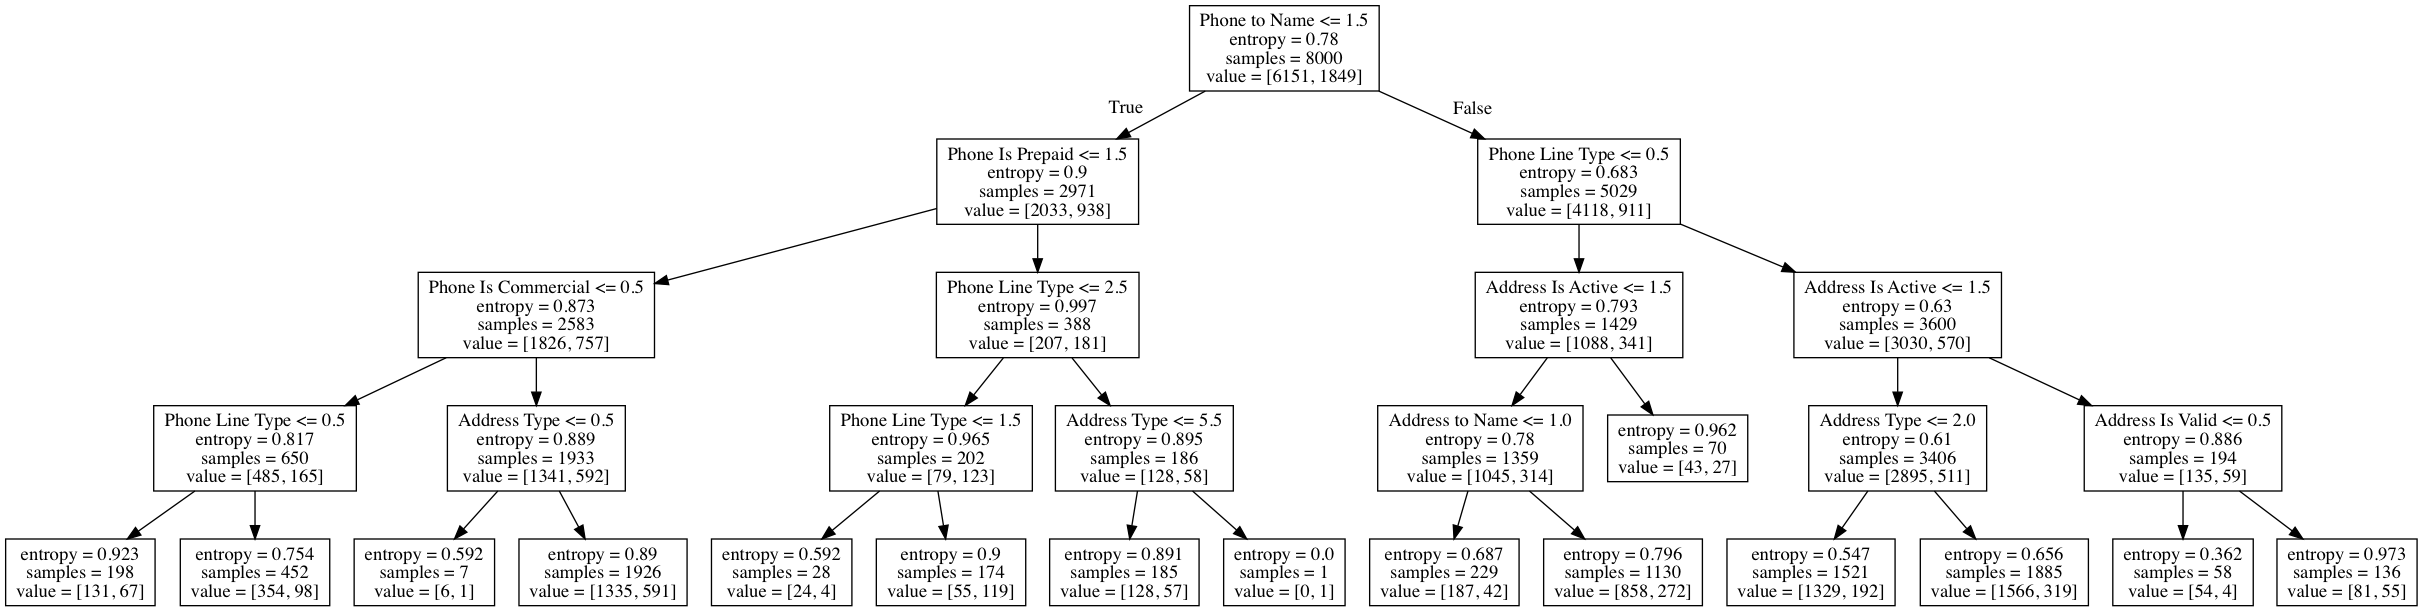

In [22]:
Image(graph.create_png()) 

In [23]:
y_test = test["Call Disposition"]
X_test = test[features]
pred = clf.predict(X_test)

In [24]:

from sklearn.metrics import accuracy_score

print 'Accuracy of decision tree',accuracy_score(y_test, pred)

Accuracy of decision tree 0.7735


  # Receiver Operating Characteristic : curve analysis

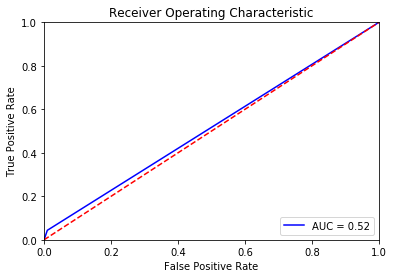

In [25]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

 # Decision Tree using Grid serach

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(
        estimator=tree.DecisionTreeClassifier(random_state=0),
        param_grid=[
        {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
        scoring='accuracy',
        cv=5)
scores = cross_val_score(gs,
            X_train,
            y_train,
            scoring='accuracy',
            cv=10)
for score in scores:
    print score
    
print('CV accuracy: %.3f +/- %.3f' % (
        np.mean(scores), np.std(scores)))

0.775280898876
0.77625
0.7675
0.7825
0.77375
0.7675
0.79
0.78375
0.78
0.780976220275
CV accuracy: 0.778 +/- 0.007


# Ensemble : Random Forest

In [27]:
train_rf, test_rf = train_test_split(df_new, test_size = 0.2)

y_train_rf = train_rf["Call Disposition"]
X_train_rf = train_rf[features]

y_test_rf = test_rf["Call Disposition"]
X_test_rf = test_rf[features]

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train_rf, y_train_rf)

In [29]:
pred_rf = clf.predict(X_test_rf)
from sklearn.metrics import accuracy_score

print 'Accuracy of Random forest',accuracy_score(y_test_rf, pred_rf)

Accuracy of Random forest 0.771


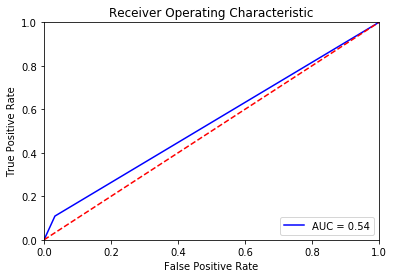

In [30]:
fpr, tpr, threshold = metrics.roc_curve(y_test_rf, pred_rf)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
## confusion metrix

from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test_rf, y_pred=pred_rf)
print(confmat)

[[1492   50]
 [ 408   50]]


# Confusion Matrix :

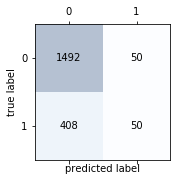

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# Feature Importance plot in Random Forest :

In [33]:
#Extract the features that contributes the most in classification of call disposition 
clf.feature_importances_

array([ 0.17614086,  0.00354559,  0.20375131,  0.06880765,  0.09499192,
        0.09284518,  0.05144436,  0.17192927,  0.05341242,  0.08313145])

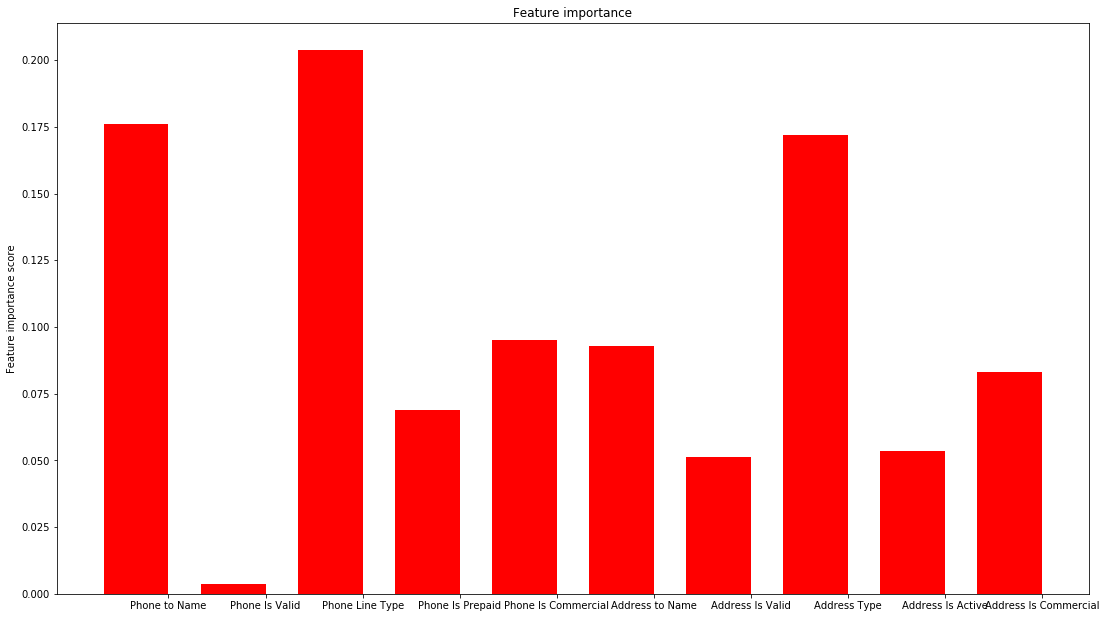

In [34]:

feature_imp =  clf.feature_importances_
N = len(feature_imp)



ind = np.arange(N)  # the x locations for the groups
width =  1/1.5      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, feature_imp, width, color='r')

fig.set_size_inches(18.5, 10.5)

# add some text for labels, title and axes ticks
ax.set_ylabel('Feature importance score')
ax.set_title('Feature importance')
ax.set_xticks(ind + width / 2)

ax.set_xticklabels( features)



plt.show()

In [35]:
df.head()

,Phone to Name,Phone Is Valid,Phone Line Type,Phone Is Prepaid,Phone Is Commercial,Address to Name,Address Is Valid,Address Type,Address Is Active,Address Is Commercial,Call Disposition
0,No match,True,Landline,False,True,No match,True,Multi unit,True,True,0
1,No match,True,Landline,False,False,No match,True,Multi unit,True,True,0
2,Match,True,Fixed VOIP,False,True,No match,True,Unknown address type,NA,True,1
3,No match,True,Fixed VOIP,False,True,No match,True,Single unit,True,False,0
4,No match,True,Fixed VOIP,False,True,No match,True,Multi unit,True,True,0


In [36]:
df[features].head()

,Phone to Name,Phone Is Valid,Phone Line Type,Phone Is Prepaid,Phone Is Commercial,Address to Name,Address Is Valid,Address Type,Address Is Active,Address Is Commercial
0,No match,True,Landline,False,True,No match,True,Multi unit,True,True
1,No match,True,Landline,False,False,No match,True,Multi unit,True,True
2,Match,True,Fixed VOIP,False,True,No match,True,Unknown address type,NA,True
3,No match,True,Fixed VOIP,False,True,No match,True,Single unit,True,False
4,No match,True,Fixed VOIP,False,True,No match,True,Multi unit,True,True


# Logistic classifier:

In [37]:
df_new1 = df

In [38]:
df_new1  = pd.get_dummies(df_new1[features])

In [39]:
df_new1["Call Disposition"] = df["Call Disposition"]

In [40]:
df_new1.head()

,Phone to Name_Match,Phone to Name_NA,Phone to Name_No match,Phone to Name_No name found,Phone Is Valid_False,Phone Is Valid_True,Phone Is Valid_NA,Phone Line Type_Fixed VOIP,Phone Line Type_Landline,Phone Line Type_Mobile,...,Address Type_PO box throwback,Address Type_Single unit,Address Type_Unknown address type,Address Is Active_False,Address Is Active_True,Address Is Active_NA,Address Is Commercial_False,Address Is Commercial_True,Address Is Commercial_NA,Call Disposition
0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,1
3,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
4,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [41]:
# Split data into 80% 20% train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_new1, test_size = 0.2)

In [42]:
features_new1 = list(df_new1.columns[0:-1])

In [43]:
y_train = train["Call Disposition"]
X_train = train[features_new1]

In [44]:
y_test = test["Call Disposition"]
X_test = test[features_new1]

In [45]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2',verbose=1)

In [46]:
clf = clf.fit(X_train,y_train)

[LibLinear]

In [47]:
pred = clf.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score

print 'Accuracy of Logistic Classifier',accuracy_score(y_test, pred)

Accuracy of Logistic Classifier 0.7785


In [49]:
clf.decision_function

<bound method LogisticRegression.decision_function of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)>

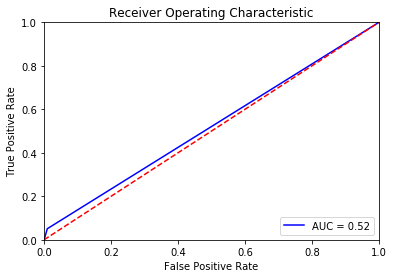

In [50]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion:

1) Based on the input data we can see that the accuracy of the most of the classifiers is around 77% as input data generally contains categorical features.<BR>
2) As we can see from feature importance plot following features contributes the most to classification of Call Dispostion and hence will lead to high percentage of score 1 <BR> 
    &emsp;&emsp;&emsp;&emsp;a) Phone Line Type.<BR>
    &emsp;&emsp;&emsp;&emsp;b) Phone To Name.<BR>
    &emsp;&emsp;&emsp;&emsp;c) Address Type.<BR>
    

# Bonus Experiment : Deep Neural Network with Keras and Theano

As a part of fun experiment with data, implementation of deep net using keras.

Below code creates a simple fully connected network with one hidden layer that contains 20 neurons.
The hidden layer uses a rectifier activation function.  
Used a one-hot encoding for dataset, the output layer create 2 output values, one for each class. The output value with the largest value will be taken as the class predicted by the model.

The network topology of this simple one-layer neural network can be summarized as:

10 inputs -> [20 hidden nodes] -> 2 outputs

Used “softmax” activation function in the output layer. This is to ensure the output values are in the range of 0 and 1.


In [51]:
import pandas
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using Theano backend.


In [52]:
input_file = "Lead_Verifiy_Response.csv"
df_nn = pd.read_csv(input_file, header = 0)

In [53]:
del df_nn['ORDER']
del df_nn['First Name']
del df_nn['Last Name']
del df_nn['Mailing Street']
del df_nn['Mailing City']
del df_nn['Mailing Zip']
del df_nn['Mailing State']
del df_nn['Phone']

In [54]:
features_nn = list(df_nn.columns[0:-1])
features_nn

['Phone to Name',
 'Phone Is Valid',
 'Phone Line Type',
 'Phone Is Prepaid',
 'Phone Is Commercial',
 'Address to Name',
 'Address Is Valid',
 'Address Type',
 'Address Is Active',
 'Address Is Commercial']

In [55]:
df_new_nn = MultiColumnLabelEncoder(columns = features_nn).fit_transform(df_nn)

In [56]:
df_new_nn.loc[df_new_nn["Call Disposition"] >1,"Call Disposition"] = 0

In [57]:
df_new_nn.head()

,Phone to Name,Phone Is Valid,Phone Line Type,Phone Is Prepaid,Phone Is Commercial,Address to Name,Address Is Valid,Address Type,Address Is Active,Address Is Commercial,Call Disposition
0,38,1,38,0,112,308,3,308,3,236,0
1,38,1,38,1634,78,308,18,308,644,804,0
2,37,1,37,1634,404,308,18,312,645,804,1
3,38,1,37,1634,404,308,18,311,646,162,0
4,38,1,37,1634,404,308,18,308,646,804,0


In [58]:
#Initialize Random Number Generator
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [59]:
dataset = df_new_nn.values
X = dataset[:,0:10].astype(float)
Y = dataset[:,10]

In [60]:
#encode the o/p
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
#print dummy_y

In [61]:
# define baseline model
# 10 input 20 hiddeen and 2 0/p
def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [62]:
#Create classifier
estimator = KerasClassifier(build_fn=baseline_model, batch_size=5, verbose=0)

In [63]:
#Evaluate The Model with k-Fold Cross Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    

In [64]:
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 65.91% (21.75%)
